In [1]:
!pip uninstall rtree -y
!pip install rtree
!pip install trimesh
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 8.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.9/688.9 kB 11.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
file_path = '/kaggle/input/meshes/test_task_meshes'

In [3]:
import trimesh
import numpy as np
import os
from scipy.spatial import cKDTree

In [ ]:
import trimesh
import numpy as np
import os

def preprocess_mesh(mesh_path, num_surface_points=25000, num_volume_points=25000):
    mesh = trimesh.load(mesh_path)
    mesh.apply_translation(-mesh.centroid)
    scale_factor = max(mesh.extents)
    mesh.apply_scale(1 / scale_factor)

    surface_points, _ = trimesh.sample.sample_surface(mesh, num_surface_points)
    min_corner, max_corner = mesh.bounding_box.vertices.min(axis=0), mesh.bounding_box.vertices.max(axis=0)
    volume_points = np.random.rand(num_volume_points, 3) * (max_corner - min_corner) + min_corner
    
    volume_distances = trimesh.proximity.signed_distance(mesh, volume_points)

    all_points = np.vstack([surface_points, volume_points])
    all_distances = np.hstack([np.zeros(num_surface_points), volume_distances]) 
    return all_points, all_distances

processed_data = []

for filename in os.listdir(file_path):
    if filename.endswith('.obj'):
        mesh_path = os.path.join(file_path, filename)
        print(mesh_path)
        points, distances = preprocess_mesh(mesh_path)
        processed_data.append((points, distances))


/kaggle/input/meshes/test_task_meshes/5.obj


/usr/local/lib/python3.10/site-packages/trimesh/triangles.py:643: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/usr/local/lib/python3.10/site-packages/trimesh/triangles.py:543: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/usr/local/lib/python3.10/site-packages/trimesh/triangles.py:546: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 * dot02) * inverse_denominator
/usr/local/lib/python3.10/site-packages/trimesh/triangles.py:547: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 * dot12) * inverse_denominator


/kaggle/input/meshes/test_task_meshes/34.obj
/kaggle/input/meshes/test_task_meshes/20.obj
/kaggle/input/meshes/test_task_meshes/19.obj
/kaggle/input/meshes/test_task_meshes/24.obj
/kaggle/input/meshes/test_task_meshes/38.obj
/kaggle/input/meshes/test_task_meshes/43.obj
/kaggle/input/meshes/test_task_meshes/10.obj
/kaggle/input/meshes/test_task_meshes/23.obj
/kaggle/input/meshes/test_task_meshes/41.obj
/kaggle/input/meshes/test_task_meshes/39.obj
/kaggle/input/meshes/test_task_meshes/22.obj
/kaggle/input/meshes/test_task_meshes/28.obj
/kaggle/input/meshes/test_task_meshes/30.obj
/kaggle/input/meshes/test_task_meshes/33.obj
/kaggle/input/meshes/test_task_meshes/17.obj


/usr/local/lib/python3.10/site-packages/trimesh/triangles.py:548: RuntimeWarning: invalid value encountered in subtract
  barycentric[:, 0] = 1 - barycentric[:, 1] - barycentric[:, 2]


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Custom Dataset class
class MeshDataset(Dataset):
    def __init__(self, data_list):
        """
        data_list: List of tuples, where each tuple contains points and corresponding distances
        """
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        points, distances = self.data_list[idx]
        points_tensor = torch.tensor(points, dtype=torch.float32)
        distances_tensor = torch.tensor(distances, dtype=torch.float32)
        return points_tensor, distances_tensor

dataset = MeshDataset(processed_data)

batch_size = 32 
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [ ]:
import torch
import torch.nn as nn

class UDFNet(nn.Module):
    def __init__(self):
        super(UDFNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)

criterion = nn.MSELoss()
model = UDFNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train(model, data_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for points, true_distances in data_loader:
            optimizer.zero_grad()

            predictions = model(points)

            loss = criterion(predictions.squeeze(), true_distances)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch}/{epochs} - Loss: {running_loss/len(data_loader)}")
    torch.save(model, 'model.pth')
    return model

epochs = 50
model = train(model, dataloader, criterion, optimizer, epochs)


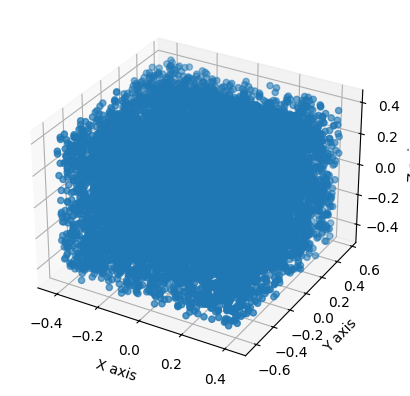

In [41]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(points[:,0], points[:,1], points[:,2])
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# plt.show()


In [38]:
# for facet in mesh.facets:
#     mesh.visual.face_colors[facet] = trimesh.visual.random_color()
# mesh.show()
